In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word-vectors-50d/glove.6B.50d.txt
/kaggle/input/british-airline-review-dataset/airline_review.csv


In [2]:
import pandas as pd 
import numpy as np 
import datetime as dt

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
from spacy import load
import nltk

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')
nlp = load('en_core_web_sm')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [4]:
df=pd.read_csv('/kaggle/input/british-airline-review-dataset/airline_review.csv')

In [5]:
df=df.drop(columns='Unnamed: 0')

In [6]:
df['date']=pd.to_datetime(df['date'],errors='coerce')

In [7]:
df.sample(3)

,rating,header,author,date,place,content,aircraft,traveller_type,seat_type,route,date_flown,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,recommended,entertainment,trip_verified
3336,9,British Airways customer review,A Ross,2014-09-28,United Kingdom,JFK to LHR - Despite the image the BA TV show ...,NaN,NaN,Economy Class,NaN,NaN,2,2,2,-1,2,no,1,NaN
366,9,"lots of space and privacy, very good seat",Guy Senior,2022-04-20,United Kingdom,My first time in the new Club World suite. E...,Boeing 787,Solo Leisure,Business Class,Chicago to London,2022-03-01,5,5,5,3,4,yes,4,Not Verified
889,3,Seats very uncomfortable,75 reviews,2019-04-01,Germany,Hamburg to Abu Dhabi via Heathrow. The 1.5h ...,A320/B788,Solo Leisure,Economy Class,Hamburg to Abu Dhabi via Heathrow,2019-04-01,1,3,2,3,4,no,-1,Verified


# EDA

In [8]:
df.isna().mean()[df.isna().mean()>0]

aircraft          0.474004
traveller_type    0.199392
seat_type         0.000553
route             0.200498
date_flown        0.201327
trip_verified     0.407633
dtype: float64

In [9]:
import nltk

tokenizer=nltk.RegexpTokenizer(r'\w+')
lemmatizer=nltk.stem.WordNetLemmatizer()
stopwords=nltk.corpus.stopwords.words('english')
from nltk.sentiment import SentimentIntensityAnalyzer
sia=SentimentIntensityAnalyzer()

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [10]:
def comment_sentiment_scores(comment):
    comment_tokenized=tokenizer.tokenize(comment)
    comment_lower=[w.lower() for w in comment_tokenized]
    comment_lemmatized=[lemmatizer.lemmatize(w) for w in comment_lower]
    comment_filtered=[w for w in comment_lemmatized if w not in stopwords]
    final_comment=' '.join(comment_filtered)
    
    score=sia.polarity_scores(final_comment)
    return score

In [11]:
scores=[]

for comment in df['content']:
    try:
        score=comment_sentiment_scores(comment)
    except:
        score=None
    scores.append(score)

In [12]:
df['Sentiment Score']=[i['compound'] if i else None for i in scores]

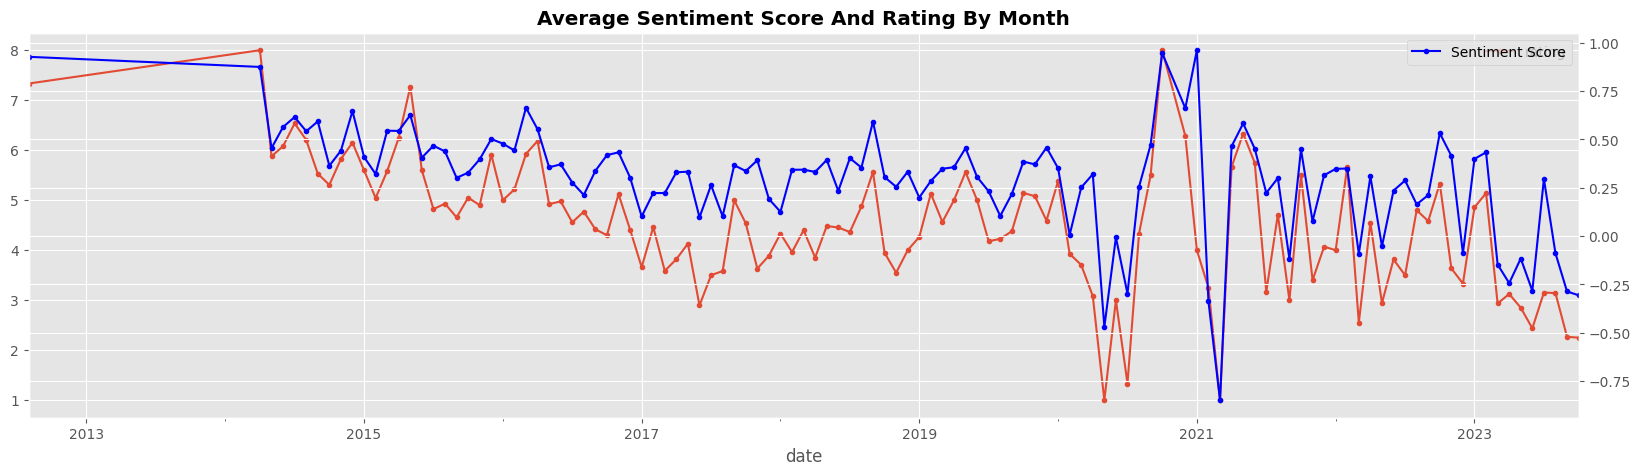

Correlation Between Rating And Sentiment Score: 0.86


In [13]:
g=df.groupby(df['date'].dt.to_period('M'))[['rating','Sentiment Score']].mean()


fig,ax=plt.subplots(figsize=(20,5))
ax2=ax.twinx()

g.plot(ax=ax, y='rating',marker='.')
g.plot(ax=ax2,y='Sentiment Score',color='blue',marker='.')
plt.title('Average Sentiment Score And Rating By Month',fontweight='bold')
plt.show()

print('Correlation Between Rating And Sentiment Score:',g['rating'].corr(g['Sentiment Score']).round(2))

# Predict whether a custumer will recommend the airline company to others or not

In [14]:
df.groupby('recommended')['Sentiment Score'].mean()

recommended
no     0.060536
yes    0.753232
Name: Sentiment Score, dtype: float64

<Axes: title={'center': 'Recommended'}, ylabel='count'>

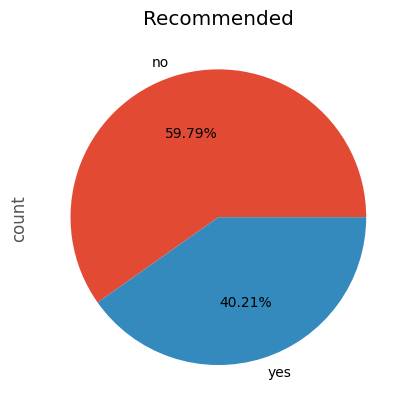

In [15]:
df['recommended'].value_counts().plot.pie(title='Recommended',autopct='%.2f%%')

In [16]:
df['recommended']=df['recommended'].map({'yes':1,'no':0})

Define vectors dictionary


In [17]:
vector_dict={}

with open('/kaggle/input/word-vectors-50d/glove.6B.50d.txt','r',encoding='utf-8') as f:
    for line in f.readlines():
        try:
            line=line.split(' ')
            vector_dict[line[0]]=np.array(line[1:],dtype=float)
        except:
            continue

In [18]:
len(vector_dict)

400000

Convert text to tokens

In [19]:
def text_to_tokens(text):
    tokenized=tokenizer.tokenize(text)
    lower=[t.lower() for t in tokenized]
    lemmatized=[lemmatizer.lemmatize(t) for t in lower]
    tokens=[t for t in lemmatized if t in vector_dict]
    
    return tokens

Create list of vectors for each text

In [20]:
def text_to_vector_list(text):
    text_as_tokens=text_to_tokens(text)

    vectors_list=[]
    for token in text_as_tokens:
        if token not in vector_dict:
            continue
        vector=vector_dict[token]
        vectors_list.append(vector)
    return np.array(vectors_list,dtype=float)

Split data into train, validation and test sets

In [21]:
df=df.sample(frac=1).reset_index(drop=True)

In [22]:
split_index_1=int(len(df)*0.7)
split_index_2=int(len(df)*0.85)

train, val, test=df.iloc[:split_index_1],df.iloc[split_index_1:split_index_2],df.iloc[split_index_2:]

len(train), len(val), len(test)

(2531, 542, 543)

Create vector sequences (X)


In [23]:
def df_to_Xy(df):
    y=df['recommended'].to_numpy().astype(int)

    vector_sequence=[]
    for text in df['content']:
        vectors_list=text_to_vector_list(text)
        if vectors_list.shape[0]==0:
            vectors_list=np.zeros(shape=(1,50))
        vector_sequence.append(vectors_list)
    
    return vector_sequence,y

In [24]:
X_train,y_train=df_to_Xy(train)
X_val,y_val=df_to_Xy(val)
X_test,y_test=df_to_Xy(test)

In [25]:
length_list=[]
for i in df_to_Xy(df)[0]:
    length_list.append(i.shape[0])

In [26]:
max=0
for i in length_list:
    if i>max:
        max=i

In [27]:
max

662

Padding to have uniform input data


In [28]:
from copy import deepcopy

def pad_X(X,desired_lngth=max):
    X_copy=deepcopy(X)

    for i, vectors_list in enumerate(X_copy):
        vector_length=vectors_list.shape[0]
        diff=desired_lngth-vector_length
        pad=np.zeros(shape=(diff,50))
        
        X_copy[i]=np.concatenate([vectors_list,pad])
    
    return np.array(X_copy).astype(float)

In [29]:
X_train=pad_X(X_train)

X_train.shape, y_train.shape

((2531, 662, 50), (2531,))

In [30]:
X_val = pad_X(X_val)

X_val.shape, y_val.shape

((542, 662, 50), (542,))

In [31]:
X_test = pad_X(X_test)

X_test.shape, y_test.shape

((543, 662, 50), (543,))

### Building LSTM Model


In [32]:
from keras.layers import Dense, LSTM, Input,Dropout
from keras import layers
from keras.models import Sequential

In [33]:
model=Sequential()
model.add(Input(shape=(max,50)))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.Flatten())
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 662, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 662, 64)           0         
                                                                 
 flatten (Flatten)           (None, 42368)             0         
                                                                 
 dense (Dense)               (None, 1)                 42369     
                                                                 
Total params: 71809 (280.50 KB)
Trainable params: 71809 (280.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint

In [35]:
cp=ModelCheckpoint('model/',save_best_only=True)

In [36]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=BinaryCrossentropy(),
    metrics=['accuracy',AUC(name='auc')]
    )

In [37]:
frequencies=df['recommended'].value_counts()
frequencies

recommended
0    2162
1    1454
Name: count, dtype: int64

In [38]:
weights={0:frequencies.sum()/frequencies[0],1:frequencies.sum()/frequencies[1]}
weights

{0: 1.6725254394079556, 1: 2.4869325997248968}

In [39]:
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,callbacks=[cp],class_weight=weights)

Epoch 1/20
80/80 [==============================] - 32s 362ms/step - loss: 1.3454 - accuracy: 0.5737 - auc: 0.6338 - val_loss: 0.6533 - val_accuracy: 0.5738 - val_auc: 0.6659
Epoch 2/20
80/80 [==============================] - 24s 297ms/step - loss: 1.2614 - accuracy: 0.6243 - auc: 0.7115 - val_loss: 0.6560 - val_accuracy: 0.5849 - val_auc: 0.7596
Epoch 3/20
80/80 [==============================] - 29s 358ms/step - loss: 1.1641 - accuracy: 0.6981 - auc: 0.7707 - val_loss: 0.6179 - val_accuracy: 0.6494 - val_auc: 0.7745
Epoch 4/20
80/80 [==============================] - 28s 357ms/step - loss: 1.1059 - accuracy: 0.7183 - auc: 0.7941 - val_loss: 0.5506 - val_accuracy: 0.7085 - val_auc: 0.7894
Epoch 5/20
80/80 [==============================] - 29s 360ms/step - loss: 1.0629 - accuracy: 0.7305 - auc: 0.8128 - val_loss: 0.5267 - val_accuracy: 0.7288 - val_auc: 0.7952
Epoch 6/20
80/80 [==============================] - 25s 309ms/step - loss: 1.0353 - accuracy: 0.7483 - auc: 0.8254 - val_loss

In [40]:
from keras.models import load_model

best_model = load_model('model/')

In [41]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, test_predictions))

17/17 [==============================] - 2s 88ms/step
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       333
           1       0.69      0.72      0.70       210

    accuracy                           0.77       543
   macro avg       0.75      0.76      0.76       543
weighted avg       0.77      0.77      0.77       543



<Axes: >

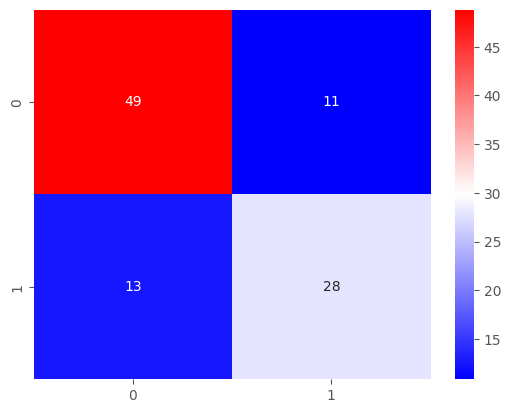

In [42]:
from sklearn import metrics

cm=metrics.confusion_matrix(test_predictions,y_test)
cm=cm/cm.sum()*100

import seaborn as sns

sns.heatmap(cm,annot=True,cmap='bwr')